In [1]:
import numpy as np
import pandas as pd
import copy

In [2]:
train_df = pd.read_excel("训练.xlsx")
test1_df = pd.read_excel("测试A.xlsx")
test2_df = pd.read_excel("测试B.xlsx")

In [3]:
new_column = test1_df.columns

In [4]:
train_y = train_df[train_df.columns[-1]]
train_y.shape

(500,)

In [5]:
train_df = train_df[new_column]

In [6]:
train_id = train_df['ID']
test1_id = test1_df['ID']
test2_id = test2_df['ID']
train_df.drop(['ID'], axis=1, inplace=True)
test1_df.drop(['ID'], axis=1, inplace=True)
test2_df.drop(['ID'], axis=1, inplace=True)

In [7]:
names = train_df.columns
dts = train_df.dtypes

In [8]:
drop_names = []
ratio = 0.1
for i in range(len(names)):
    n = names[i]
    tp = dts[i]
    trd = train_df[n]
    ted = test1_df[n]
    if 'object' == str(tp):
        continue
    else:
        misstr = np.sum(trd.isnull())/500
        misste = np.sum(ted.isnull())/100
        if np.abs(misstr-misste) > ratio:
            drop_names.append(n)
        else:
            if 'int' in str(tp):
                continue
            trrd = trd[trd.notnull()]
            terd = ted[ted.notnull()]
            m1 = np.mean(trrd)
            s1 = np.std(trrd)
            m2 = np.mean(terd)
            s2 = np.std(terd)
            if np.abs(m1-m2)>ratio*np.abs(m1) and np.abs(s1-s2)>ratio*np.abs(s1):
                drop_names.append(n)
print(len(drop_names))

855


In [9]:
train_df.drop(drop_names, axis=1, inplace=True)
test1_df.drop(drop_names, axis=1, inplace=True)
test2_df.drop(drop_names, axis=1, inplace=True)

In [10]:
train_df.shape

(500, 7172)

In [11]:
names = train_df.columns
dfs = train_df.dtypes

In [12]:
# ints or strings
ints = []
for i in range(len(names)):
    if 'int' in str(dfs[i]) or 'object' in str(dfs[i]):
        ints.append(names[i])
print(len(ints))

1749


In [13]:
df_X = pd.concat([train_df, test1_df, test2_df], axis=0)
#df_X = pd.concat([train_df, test1_df], axis=0)

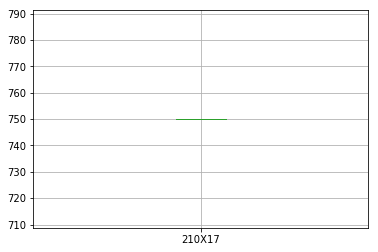

In [16]:
%matplotlib inline
df_X.boxplot(column=ints[0], return_type='axes')

In [14]:
remains1 = []
remains2 = []
tobedrop = []
for n in ints:
    lu1 = len(train_df[n].unique())
    lu2 = len(df_X[n].unique())
    if lu1 < 10 and lu1 > 1:
        remains1.append(n)
    if lu2 < 10 and lu2 > 1:
        remains2.append(n)
    if lu1 != lu2:
        tobedrop.append(n)
print(len(remains1), len(remains2), len(tobedrop))

405 473 766


In [15]:
print(len(set(tobedrop) & set(remains1)), len(set(tobedrop) & set(remains2)), len(set(tobedrop) & set(remains2) & set(remains1)))

111 179 97


In [16]:
toberemain = list(set(remains1) & set(remains2) - set(tobedrop))
print(len(toberemain))

294


In [17]:
def dict2list(dic:dict):
    ''' 将字典转化为列表 '''
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

def LastRemainJudge(column):
    unique = set(column)
    uf = {}
    for u in unique:
        uf[u] = 0
    for c in column:
        uf[c] += 1
    sl = sorted(dict2list(uf), key = lambda x:x[1], reverse=True)
    x = sl[0][1]/len(column)
    sl = np.array(sl)
    if x < 0.8:
        #print(sl[:, 1]/len(column))
        return True
    else:
        return False

In [18]:
lm1 = []
lm2 = []
for n in toberemain:
    if LastRemainJudge(train_df[n]):
        lm1.append(n)
    if LastRemainJudge(df_X[n]):
        lm2.append(n)
print(len(lm1), len(lm2), len(set(lm1)&set(lm2)))

185 189 183


In [19]:
# now, separate trains into float, int and str

In [20]:
names = df_X.columns
dts = df_X.dtypes

In [21]:
dfx_float_n = []
dfx_onehot_n = list(set(lm1) & set(lm2))
print(len(dfx_onehot_n))
for i in range(len(names)):
    n = names[i]
    d = dts[i]
    if 'float' in str(d):
        dfx_float_n.append(n)
print(len(dfx_float_n))
dfx_float = df_X[dfx_float_n]
dfx_onehot = df_X[dfx_onehot_n]
print(dfx_float.shape, dfx_onehot.shape)

183
5628
(721, 5628) (721, 183)


In [22]:
drop_names = []
names = dfx_float.columns
for n in names:
    x = np.sum(dfx_float[n].isnull())
    if x > 300:
        drop_names.append(n)
print(len(drop_names))

64


In [25]:
dfx_float.drop(drop_names, axis=1, inplace=True)

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
means = []
stds = []
drop_names = []
names = dfx_float.columns
for n in names:
    c = dfx_float[n]
    r = c[c.notnull()]
    tmpm = np.mean(r)
    tmps = np.std(r)
    means.append(tmpm)
    stds.append(tmps)
    if tmps == 0:
        drop_names.append(n)
print(len(set(means)), len(set(stds)))
print(len(drop_names))

2149 2149
0


In [27]:
# not move sames first, fill nan
added = set()
sames = []
for i in range(len(names)):
    tmpsl = []
    tmpsl.append(i)
    for j in range(i+1, len(names)):
        if means[i] == means[j] and stds[i] == stds[j]:
            if i not in added:
                added.add(i)
            if j not in added:
                added.add(j)
                tmpsl.append(j)
    if len(tmpsl) > 1:
        sames.append(tmpsl)
print(len(sames))

701


In [28]:
names = dfx_float.columns
drop_names = []
for i in sames:
    for j in i[1:]:
        drop_names.append(names[j])
print(len(drop_names))

3148


In [29]:
print(dfx_float.shape)

(721, 5298)


In [30]:
import copy
trainx_float = copy.copy(dfx_float)
trainx_float.drop(drop_names, axis=1, inplace=True)
print(trainx_float.shape)

(721, 2150)


In [31]:
names = trainx_float.columns
for n in names:
    c = trainx_float[n]
    r = c[c.notnull()]
    tmpm = np.mean(r)
    tmps = np.std(r)
    assert tmps>0
    trainx_float[n][c.isnull()] = tmpm
print(np.sum(trainx_float.isnull().values))

0


In [32]:
# it shall be that there is only thre lines with nan in log1p
mid = trainx_float-np.min(trainx_float)+1
trainx_log1p = np.log1p(mid)
del mid
print(np.sum(trainx_log1p.isnull().values))

0


In [33]:
for n in names:
    m1 = np.mean(trainx_float[n])
    s1 = np.std(trainx_float[n])
    assert s1 > 0
    trainx_float[n] = (trainx_float[n]-m1)/s1
    m2 = np.mean(trainx_log1p[n])
    s2 = np.std(trainx_log1p[n])
    assert s2 > 0
    trainx_log1p[n] = (trainx_log1p[n]-m2)/s2

In [34]:
# make onehots onehot
ohnames = dfx_onehot.columns
for i in range(len(ohnames)):
    n = ohnames[i]
    tmp = pd.get_dummies(dfx_onehot[n], prefix='onehot_'+str(i))
    dfx_onehot = pd.concat([dfx_onehot, tmp], axis=1)
    print(dfx_onehot.shape)

(721, 190)
(721, 192)
(721, 194)
(721, 200)
(721, 206)
(721, 209)
(721, 216)
(721, 222)
(721, 226)
(721, 233)
(721, 237)
(721, 240)
(721, 243)
(721, 250)
(721, 256)
(721, 265)
(721, 272)
(721, 275)
(721, 283)
(721, 286)
(721, 289)
(721, 291)
(721, 296)
(721, 304)
(721, 306)
(721, 308)
(721, 313)
(721, 320)
(721, 325)
(721, 331)
(721, 338)
(721, 343)
(721, 346)
(721, 350)
(721, 355)
(721, 357)
(721, 365)
(721, 370)
(721, 374)
(721, 378)
(721, 380)
(721, 385)
(721, 387)
(721, 391)
(721, 393)
(721, 395)
(721, 400)
(721, 402)
(721, 405)
(721, 407)
(721, 411)
(721, 417)
(721, 424)
(721, 433)
(721, 442)
(721, 445)
(721, 447)
(721, 449)
(721, 453)
(721, 459)
(721, 464)
(721, 467)
(721, 470)
(721, 476)
(721, 478)
(721, 487)
(721, 489)
(721, 491)
(721, 499)
(721, 505)
(721, 510)
(721, 514)
(721, 519)
(721, 523)
(721, 530)
(721, 534)
(721, 538)
(721, 542)
(721, 550)
(721, 552)
(721, 556)
(721, 558)
(721, 560)
(721, 569)
(721, 571)
(721, 573)
(721, 577)
(721, 581)
(721, 587)
(721, 589)
(721, 598)

In [35]:
dfx_onehot.drop(ohnames, axis=1, inplace=True)
print(dfx_onehot.shape)

(721, 791)


In [36]:
dfx_float = trainx_float
dfx_log1p = trainx_log1p

In [37]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
#lr = LinearRegression(normalize=True)
#b = BaggingRegressor(lr)
#b.fit(df_X[:500], train_y)

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
names = dfx_float.columns
lr = LinearRegression()
lr.fit(dfx_float[:500], train_y)
fn = names[lr.coef_>0]
lr = LinearRegression()
lr.fit(dfx_log1p[:500], train_y)
ln = names[lr.coef_>0]
#lr = LinearRegression()
#lr.fit(dfx_exp[:500], train_y)
#en = names[lr.coef_>0]

In [39]:
print(len(fn), len(ln))
print(len(set(fn) & set(ln) ))

1123 1109
942


In [40]:
xfloatlr = dfx_float[fn]
xlog1plr = dfx_log1p[ln]
#xexplr = dfx_exp[en]

In [41]:
lr = LinearRegression()
lr.fit(dfx_onehot[:500], train_y)
print(np.sum(lr.coef_>0))
names = dfx_onehot.columns
xonehot = dfx_onehot[names[lr.coef_>0]]
print(xonehot.shape)

391
(721, 391)


In [42]:
def MSE(y_raw, y_pred):
    print(np.mean(np.square(y_raw-y_pred)))

In [43]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV 

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [44]:
XGBRegressor().get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [45]:
subxtrain, subxval, subytrain, subyval = train_test_split(dfx_log1p[:500].values, train_y.values, test_size=0.2, random_state=20)


In [111]:

tuned_parameters = {'objective':['reg:linear', 'reg:gamma'], 'max_depth':[1,2,3,4,5,6],
                    'gamma':[0, 1e-3, 1e-2,  1e-4], 'subsample':[0.85, 0.7]}
scores = ['MSE']
clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(subxtrain, subytrain)
print("Best parameters set found on development set:")  
print()  
print(clf.best_params_)  
print()  
print("Grid scores on development set:")  
print()  
for params, mean_score, scores in clf.grid_scores_:  
    print("%0.3f (+/-%0.03f) for %r"  
              % (mean_score, scores.std() * 2, params))  
print()
print("The scores are computed on the full evaluation set.")  
print()  
y_true, y_pred = subyval, clf.predict(subxval)
print(MSE(y_true, y_pred))

Best parameters set found on development set:

{'gamma': 0.0001, 'max_depth': 5, 'objective': 'reg:gamma', 'subsample': 0.85}

Grid scores on development set:

-0.036 (+/-0.010) for {'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'subsample': 0.85}
-0.035 (+/-0.011) for {'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'subsample': 0.7}
-0.035 (+/-0.011) for {'gamma': 0, 'max_depth': 1, 'objective': 'reg:gamma', 'subsample': 0.85}
-0.036 (+/-0.011) for {'gamma': 0, 'max_depth': 1, 'objective': 'reg:gamma', 'subsample': 0.7}
-0.036 (+/-0.009) for {'gamma': 0, 'max_depth': 2, 'objective': 'reg:linear', 'subsample': 0.85}
-0.035 (+/-0.012) for {'gamma': 0, 'max_depth': 2, 'objective': 'reg:linear', 'subsample': 0.7}
-0.036 (+/-0.011) for {'gamma': 0, 'max_depth': 2, 'objective': 'reg:gamma', 'subsample': 0.85}
-0.036 (+/-0.011) for {'gamma': 0, 'max_depth': 2, 'objective': 'reg:gamma', 'subsample': 0.7}
-0.037 (+/-0.012) for {'gamma': 0, 'max_depth': 3, 'objective': 'reg:lin

In [92]:
xgb = XGBRegressor(gamma=0.001, max_depth=1, objective='reg:linear', subsample=0.7)

In [93]:
ans = pd.read_csv('under004/answer_Synchronous_paramstack_log1_xgb_20180109_0p04.csv', header=None)
ans[1].shape

(100,)

In [94]:
xgb.fit(dfx_log1p[:500], train_y)
#test1_pred = Model_TripleTest(xfloatlr[:500], xlog1plr[:500], xexplr[:500], xonehot[:500], train_y, xfloatlr[500:600], xlog1plr[500:600], xexplr[500:600], xonehot[500:600])
test1_pred = xgb.predict(dfx_log1p[500:600])
MSE(test1_pred, ans[1])
#save = pd.DataFrame({'ID':test1_id, 'value':test1_pred})
#save.to_csv('answer_Synchronous_param_log1_xgb_20180109.csv', index=False, header=False)

0.0026511319420319712


In [46]:
from sklearn.model_selection import KFold 

In [47]:
kf = KFold(n_splits=5, random_state=2018)
def get_oof(rgr, xtrain, ytrain, xtest, lenot):
    oof_train = np.zeros((lenot,))
    oof_test = np.zeros((100,))
    oof_test_skf = np.empty((5, 100))
    for i, (train_index, test_index) in enumerate(kf.split(xtrain)):
        kf_xtrain = xtrain[train_index]
        kf_ytrain = ytrain[train_index]
        kf_xtest = xtrain[test_index]
        rgr.fit(kf_xtrain, kf_ytrain)
        oof_train[test_index] = rgr.predict(kf_xtest)
        oof_test_skf[i, : ] = rgr.predict(xtest)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [55]:
xgb = XGBRegressor(colsample_bytree=0.5, gamma=0.01, max_depth=5, objective='reg:linear', reg_lambda=1, subsample=0.8)
tr_pred, te_pred = get_oof(xgb, dfx_log1p[:500].values, train_y.values, dfx_log1p[500:600].values, 500)
MSE(tr_pred, train_y.values)
xgb = XGBRegressor(colsample_bytree=0.5, gamma=0.01, max_depth=5, objective='reg:linear', reg_lambda=1, subsample=0.8)
tr_pred, te_pred = get_oof(xgb, subxtrain, subytrain, subxval, 500)
MSE(tr_pred, subytrain)
MSE(te_pred, subyval)

0.051072234192
1.67251818311
0.0414116886996


In [53]:
test1_pred = te_pred.reshape(100)
save = pd.DataFrame({'ID':test1_id, 'value':test1_pred})
save.to_csv('answer_Synchronous_paramstack_log_xgb_20180111.csv', index=False, header=False)

In [54]:
tuned_parameters = {'objective':['reg:linear', 'reg:gamma'], 'max_depth':[1,2,3,4,5,6],
                    'gamma':[0, 1e-3, 1e-2,  1e-4], 'subsample':[0.85, 0.8, 0.75, 0.7],
                   'colsample_bytree':[0.5, 0.75, 1], 'reg_lambda':[1,2]}
scores = ['MSE']
clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(subxtrain, subytrain)
print("Best parameters set found on development set:")  
print()  
print(clf.best_params_)  
print()  
print("Grid scores on development set:")  
print()  
for params, mean_score, scores in clf.grid_scores_:  
    print("%0.3f (+/-%0.03f) for %r"  
              % (mean_score, scores.std() * 2, params))  
print()
print("The scores are computed on the full evaluation set.")  
print()  
y_true, y_pred = subyval, clf.predict(subxval)
print(MSE(y_true, y_pred))
y_pred = clf.predict(subxtrain)
print(MSE(y_pred, subytrain))

Best parameters set found on development set:

{'colsample_bytree': 0.5, 'gamma': 0.01, 'max_depth': 5, 'objective': 'reg:linear', 'reg_lambda': 1, 'subsample': 0.8}

Grid scores on development set:

-0.037 (+/-0.006) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg_lambda': 1, 'subsample': 0.85}
-0.038 (+/-0.007) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg_lambda': 1, 'subsample': 0.8}
-0.038 (+/-0.005) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg_lambda': 1, 'subsample': 0.75}
-0.037 (+/-0.004) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg_lambda': 1, 'subsample': 0.7}
-0.038 (+/-0.005) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg_lambda': 2, 'subsample': 0.85}
-0.038 (+/-0.006) for {'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 1, 'objective': 'reg:linear', 'reg

In [46]:
def Model_TripleTest(x1, x2, x3, x4, y, vx1, vx2, vx3, vx4):
    xgb1 = BaggingRegressor(XGBRegressor())
    xgb1.fit(x1, y)
    xgb2 = BaggingRegressor(XGBRegressor())
    xgb2.fit(x2, y)
    xgb3 = BaggingRegressor(XGBRegressor())
    xgb3.fit(x3, y)
    xgb4 = BaggingRegressor(XGBRegressor())
    xgb4.fit(x4, y)
    yp1 = xgb1.predict(vx1)
    yp2 = xgb2.predict(vx2)
    yp3 = xgb3.predict(vx3)
    yp4 = xgb4.predict(vx4)
    #return (yp1+yp2+yp3)/3
    xx = pd.concat([x1, x2, x3, x4], axis=1).values
    vxx = pd.concat([vx1, vx2, vx3, vx4], axis=1).values
    xgb5 = BaggingRegressor(XGBRegressor())
    xgb5.fit(xx, y)
    yp5 = xgb4.predict(vxx)
    return (yp1+yp2+yp3+yp4+yp5)/5

In [47]:
x1, vx1, y1, vy1 = train_test_split(dfx_float[:500], train_y, test_size=0.2, random_state=20)
x2, vx2, y2, vy2 = train_test_split(dfx_log1p[:500], train_y, test_size=0.2, random_state=20)
x3, vx3, y3, vy3 = train_test_split(dfx_exp[:500], train_y, test_size=0.2, random_state=20)
x4, vx4, y4, vy4 = train_test_split(dfx_onehot[:500], train_y, test_size=0.2, random_state=20)
print(np.sum(y1 != y2))
print(np.sum(y1 != y3))
yp = Model_TripleTest(x1, x2, x3, x4, y1, vx1, vx2, vx3, vx4)
print(MSE(vy1, yp))

0
0
0.02554792356804205
None


In [48]:
test1_pred = Model_TripleTest(dfx_float[:500], dfx_log1p[:500], dfx_exp[:500], dfx_onehot[:500], train_y, dfx_float[500:600], dfx_log1p[500:600], dfx_exp[500:600], dfx_onehot[500:600])
save = pd.DataFrame({'ID':test1_id, 'value':test1_pred})
save.to_csv('answer_Synchronous_merge5_20180105.csv', index=False, header=False)

In [49]:
x1, vx1, y1, vy1 = train_test_split(xfloatlr[:500], train_y, test_size=0.2, random_state=20)
x2, vx2, y2, vy2 = train_test_split(xlog1plr[:500], train_y, test_size=0.2, random_state=20)
x3, vx3, y3, vy3 = train_test_split(xexplr[:500], train_y, test_size=0.2, random_state=20)
x4, vx4, y4, vy4 = train_test_split(xonehot[:500], train_y, test_size=0.2, random_state=20)
print(np.sum(y1 != y2))
print(np.sum(y1 != y3))
yp = Model_TripleTest(x1, x2, x3, x4, y1, vx1, vx2, vx3, vx4)
print(MSE(vy1, yp))

0
0
0.024715091798099668
None
